<a href="https://colab.research.google.com/github/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/blob/main/Crude_PalmOil_Price_Prediction_SARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Load Basic Libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
from pandas import read_csv
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]
import os
import matplotlib 
import scipy 
import sklearn

In [31]:
#Applying configurations for the quality of the image
plt.rcParams["figure.figsize"] = [12, 5]            
#plt.rcParams['figure.dpi'] = 100                  
plt.rc('font', size=8)                             
plt.rc('axes', titlesize=14)                       
plt.rc('axes', labelsize=14)                       
plt.rc('xtick', labelsize=10)                      
plt.rc('ytick', labelsize=10)                      
plt.rc('legend', fontsize=10)                      


In [32]:
#Read our data
path = 'https://raw.githubusercontent.com/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/main/Data/data.csv'
df = read_csv(path, parse_dates=True)
#df = read_csv(path,index_col='Month', parse_dates=True)
df.head()

,Month,Price,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%




*   Our data first column is Month, so we need to rename it to date
*   The second column is price, so we rename to cpo_pri (crude palm oil price)



In [33]:
#renaming Month column to date
df.rename(columns={'Month': 'date', 'Price': 'cpo_pri'}, inplace=True)
df.head()

,date,cpo_pri,Change
0,1993-03,408,-
1,1993-04,392,-3.92%
2,1993-05,371,-5.36%
3,1993-06,356,-4.04%
4,1993-07,362,1.69%




*   We remove the Change column because it is not needed



In [34]:
#Delete change column
del df['Change']



*   Convert the date from object to datetime




In [35]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     361 non-null    datetime64[ns]
 1   cpo_pri  361 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 5.8+ KB


In [36]:
# Change the data index from string to date
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1993-03-01 to 2023-03-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cpo_pri  361 non-null    object
dtypes: object(1)
memory usage: 5.6+ KB




*  We need to remove commas from the dataframe
*  We also need to change the type of cpo_pri from object to float



In [37]:
#Remove the commas from the data
df["cpo_pri"] = [float(str(i).replace(",", "")) for i in df["cpo_pri"]]

df.dtypes

cpo_pri    float64
dtype: object

Plot the Data

In [38]:
import plotly.io as pio
pio.renderers.default = "colab"
df.iplot(title="Monthly Crude Palm Oil Price Between March 1993 to March 2023")

###Decompose the Time-Series

We'll need to break down our time series into three parts: seasonal, trend, and residual. There are other approaches, but the simplest is to use statsmodels.

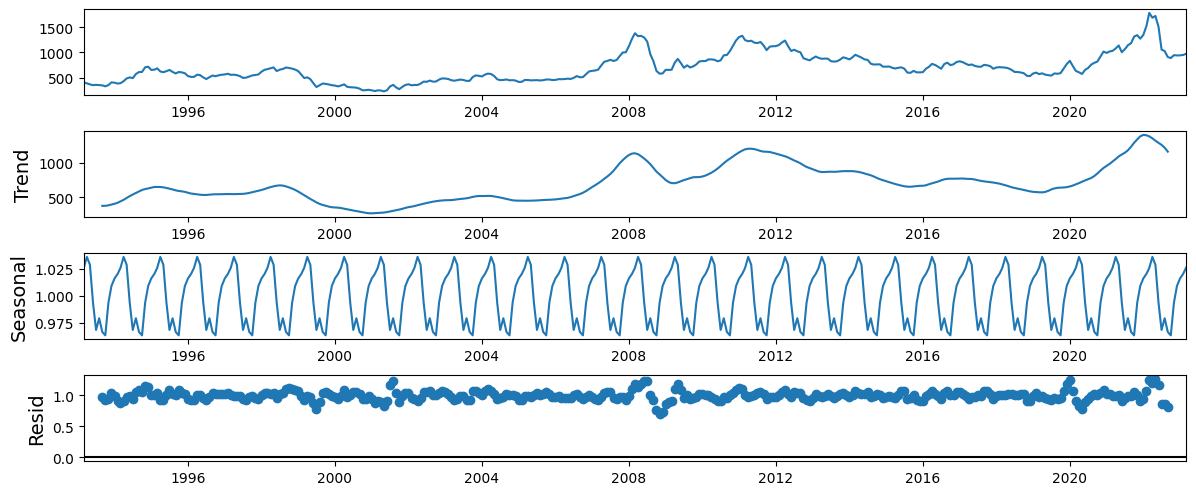

In [40]:
#Statsmodels will be used to decompose this time series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')

fig = result.plot()

The plot itself demonstrates that our time series contains a'seasonal' component

###Train Test Split



*   For the Test, we'll need to remove a section of our most recent data, say from January of 2016.
*   After splitting up the test section, we'll train on the remaining data.



In [41]:
#Splitting the data

def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [42]:
test_split = 0.15
df_train, df_test = split_data(df, test_split)

train: 307 , test: 54


In [43]:
df_train #1993-03-01 to 2018-09-01

,cpo_pri
date,
1993-03-01,408.00
1993-04-01,392.00
1993-05-01,371.00
1993-06-01,356.00
1993-07-01,362.00
...,...
2018-05-01,687.29
2018-06-01,656.50
2018-07-01,616.14


In [44]:
df_test  #2020-09-01 to 2023-03-01

,cpo_pri
date,
2018-10-01,590.32
2018-11-01,539.10
2018-12-01,535.02
2019-01-01,584.58
2019-02-01,602.97
2019-03-01,573.02
2019-04-01,588.45
2019-05-01,563.20
2019-06-01,552.19


In [45]:
#Checking for stationarity
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [46]:
# Getting the AIC score
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [47]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

In [48]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

###Plotting the ACF and PACF

<Axes: xlabel='date'>

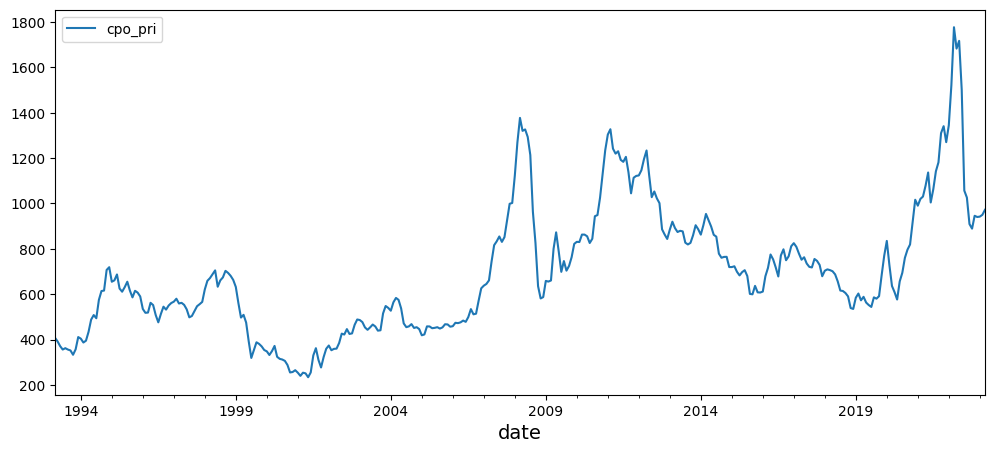

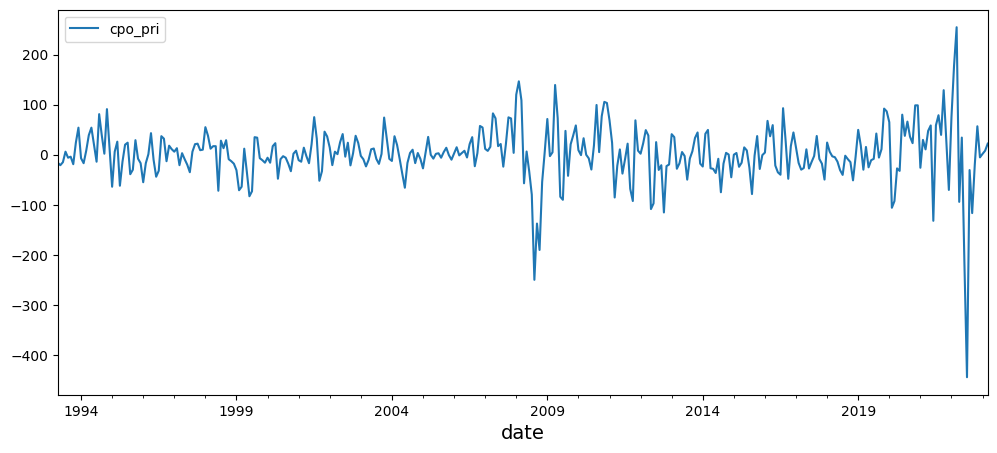

In [49]:
# plt.rcParams["figure.figsize"] = [16, 4]
df.plot()
life_diff = df.diff().dropna()
life_diff.plot()

In [50]:
#Checking for stationarity
check_stationarity(life_diff)

'Stationary	 p-value:2.4432579033101085e-05 	 lags:15


('Stationary', 2.4432579033101085e-05)

AttributeError: ignored

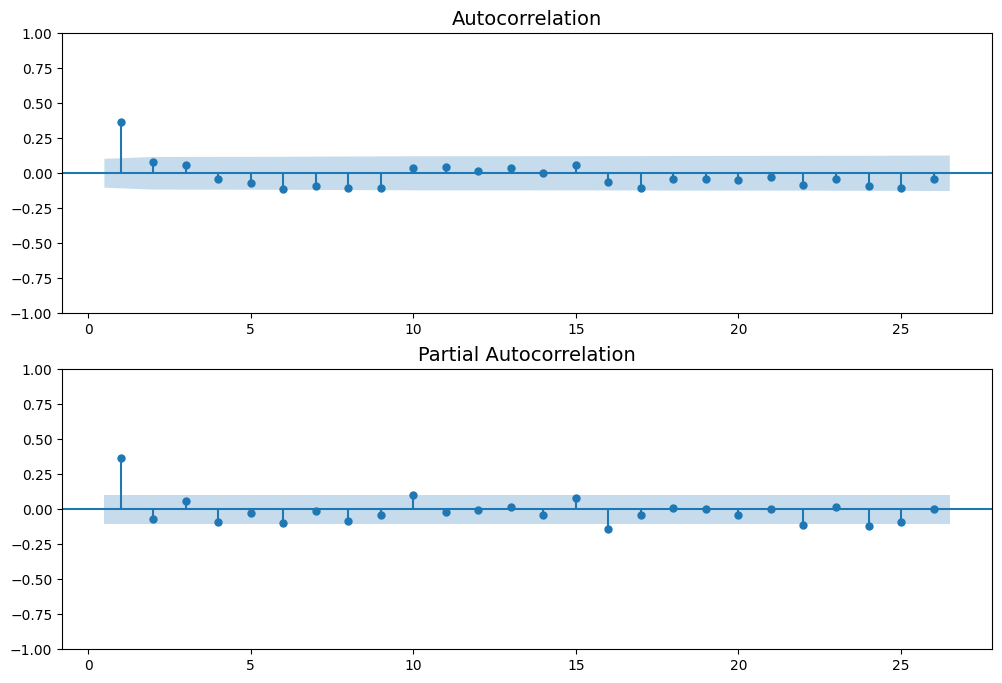

In [52]:
#Plotting the autocorrelation
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)
plt.show()

<Axes: xlabel='date'>

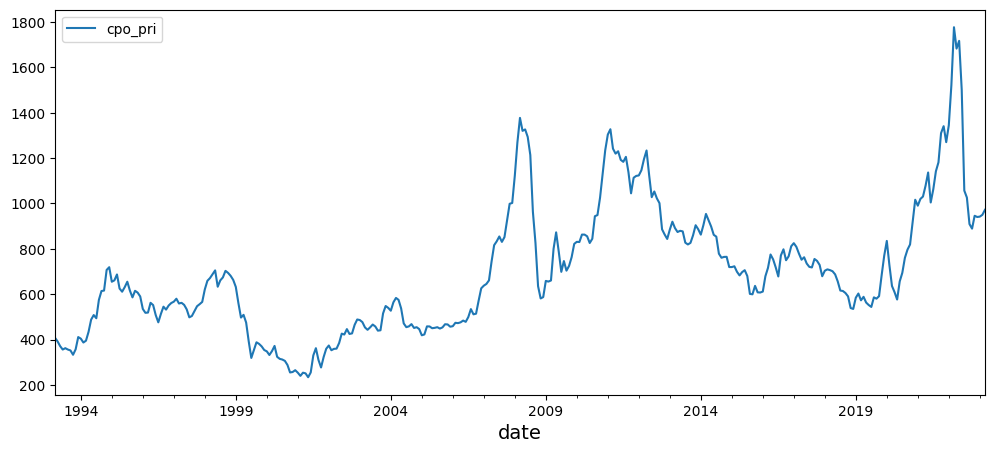

In [ ]:
df.plot()

In [ ]:
df_diff_12 = df.diff(12).dropna()

In [ ]:
check_stationarity(df_diff_12)

'Stationary	 p-value:5.3145752032489796e-05 	 lags:15


('Stationary', 5.3145752032489796e-05)

In [ ]:
df_diff_12_1 = df.diff(12).diff(1).dropna()
check_stationarity(df_diff_12_1)

'Stationary	 p-value:3.443011248419225e-06 	 lags:13


('Stationary', 3.443011248419225e-06)

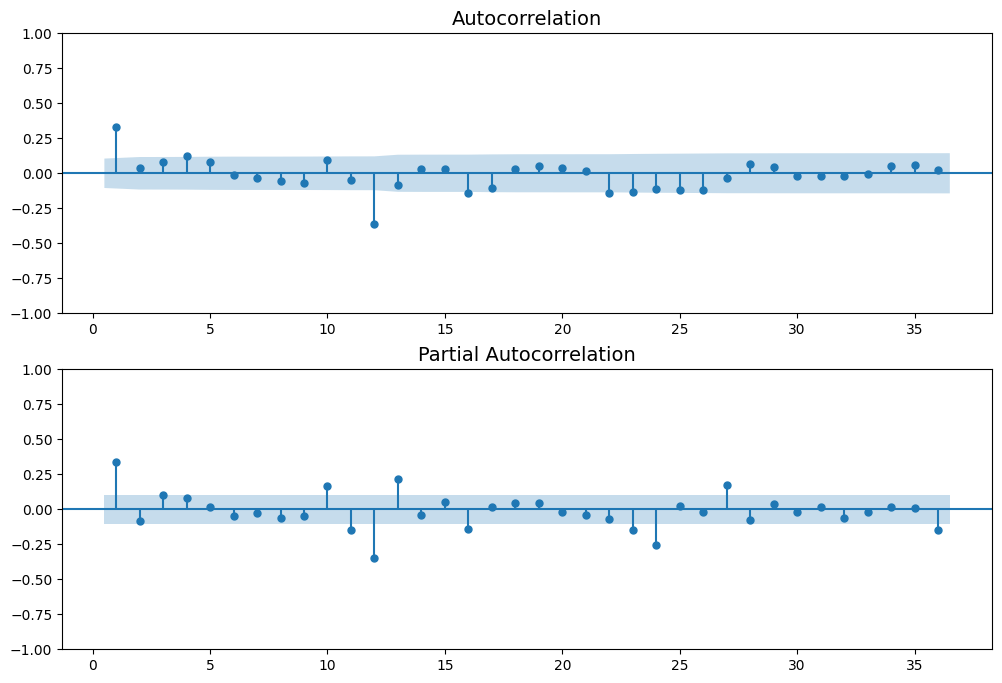

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(df_diff_12_1, zero=False, ax=ax[1], lags=36)
plt.show()

##SARIMAX Model

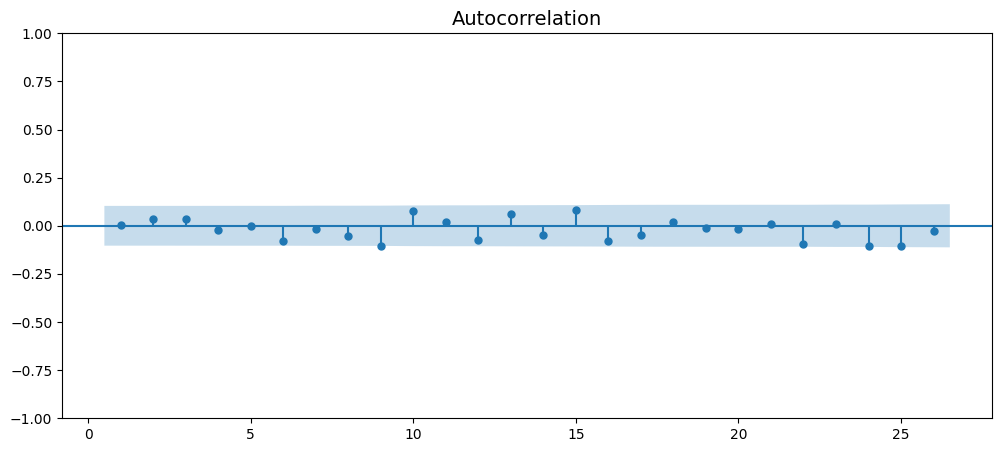

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()

<Axes: xlabel='date'>

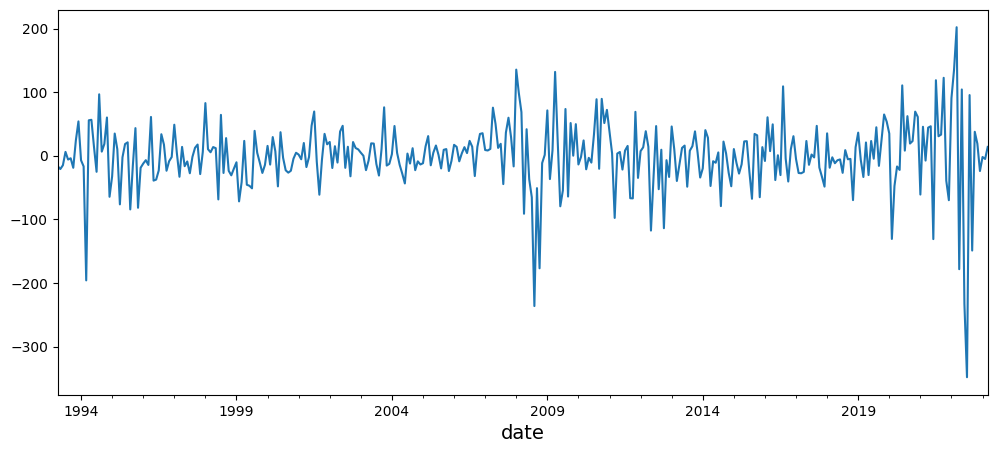

In [ ]:
#Plot the residual
model.resid[1:].plot()

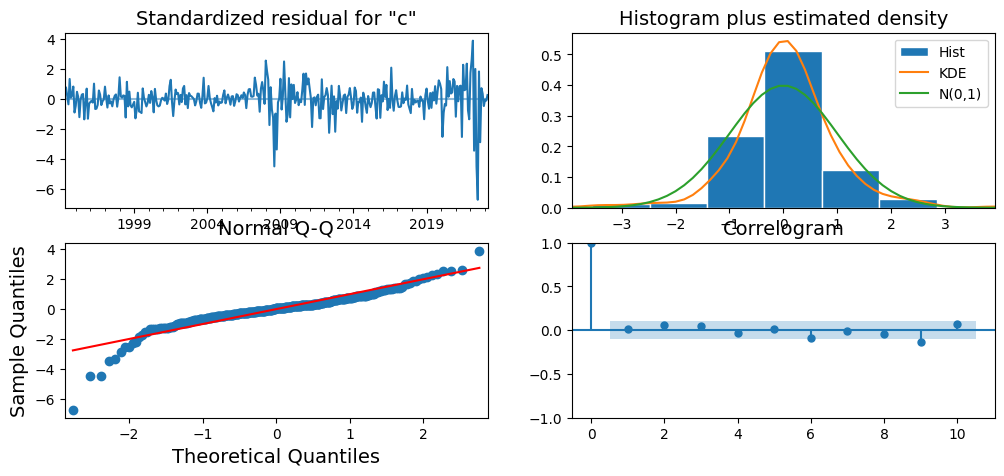

In [ ]:
#Plotting the model diagnostics
model.plot_diagnostics();

In [ ]:
model.resid[1:]

date
1993-04-01   -16.397247
1993-05-01   -20.968163
1993-06-01   -14.959288
1993-07-01     6.029045
1993-08-01    -6.011706
                ...    
2022-11-01    18.975018
2022-12-01   -24.028488
2023-01-01    -2.011380
2023-02-01    -5.116410
2023-03-01    13.828565
Length: 360, dtype: float64

##Forecasting with SARIMA Model

In [ ]:
#Fitting a SARIMA Model
sarima_model = SARIMAX(df_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

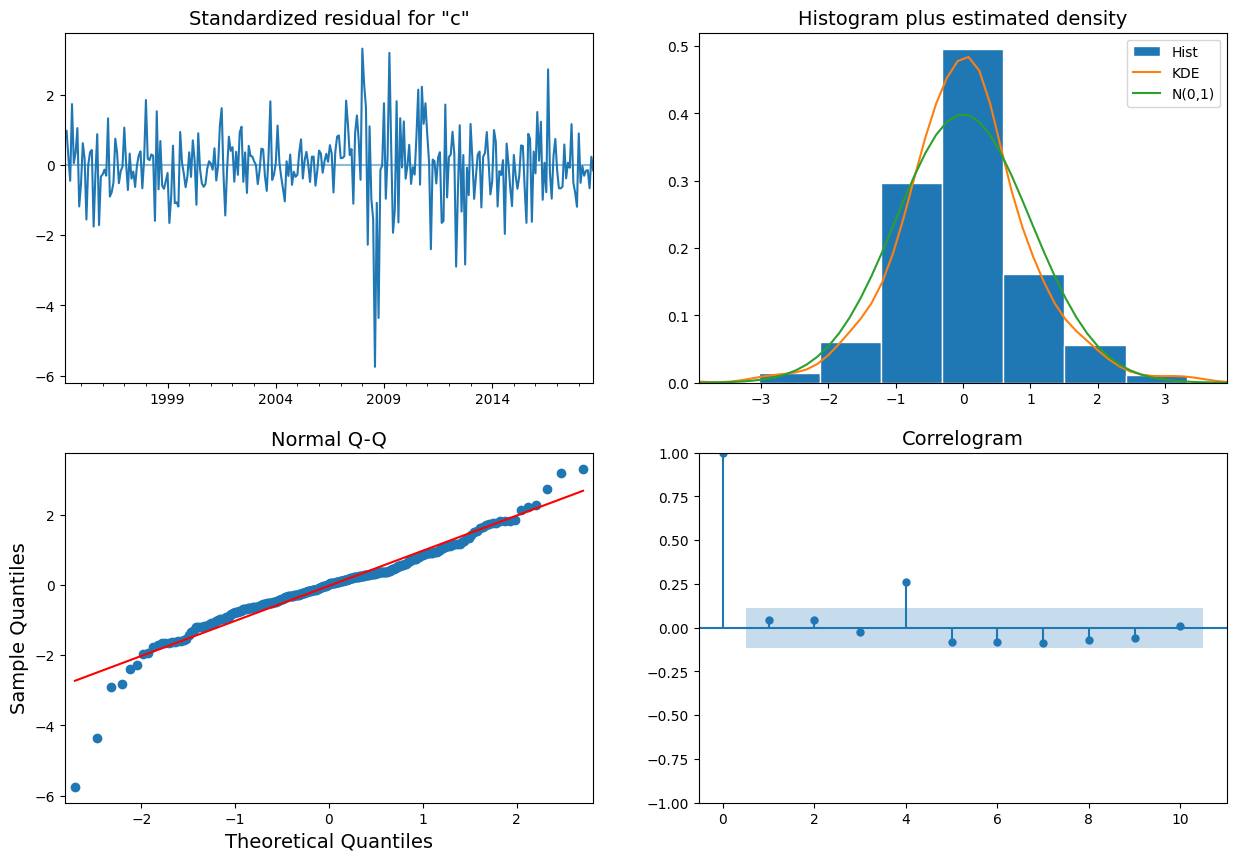

In [ ]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            cpo_pri   No. Observations:                  307
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1518.387
Date:                            Wed, 19 Apr 2023   AIC                           3042.774
Time:                                    01:09:16   BIC                           3053.825
Sample:                                03-01-1993   HQIC                          3047.200
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4100      0.053      7.695      0.000       0.306       0.514
ma.S.L12      -0.9929      0.387     -2.566      0.010      -1.751      -0.235
sigma2      1580.1059    579.801      2.725      0.006     443.716    2716.496
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):               305.29
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.69
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

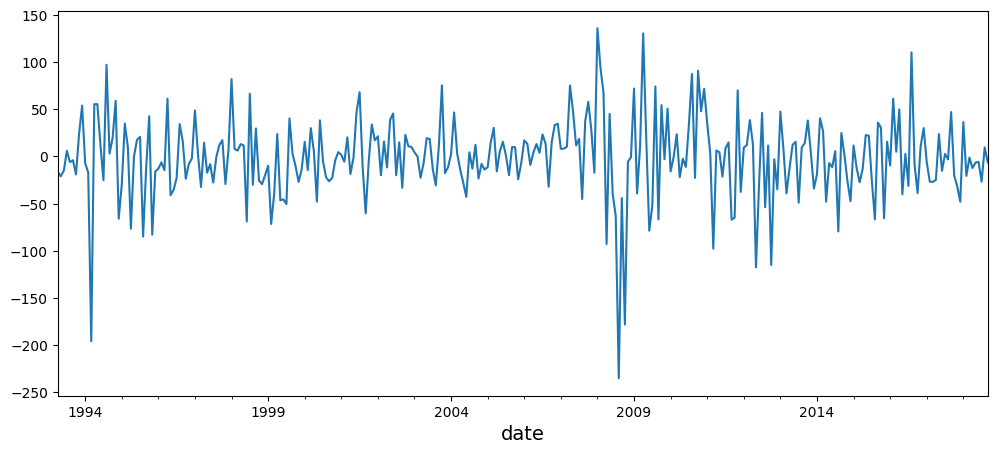

In [ ]:
model.resid[1:].plot()

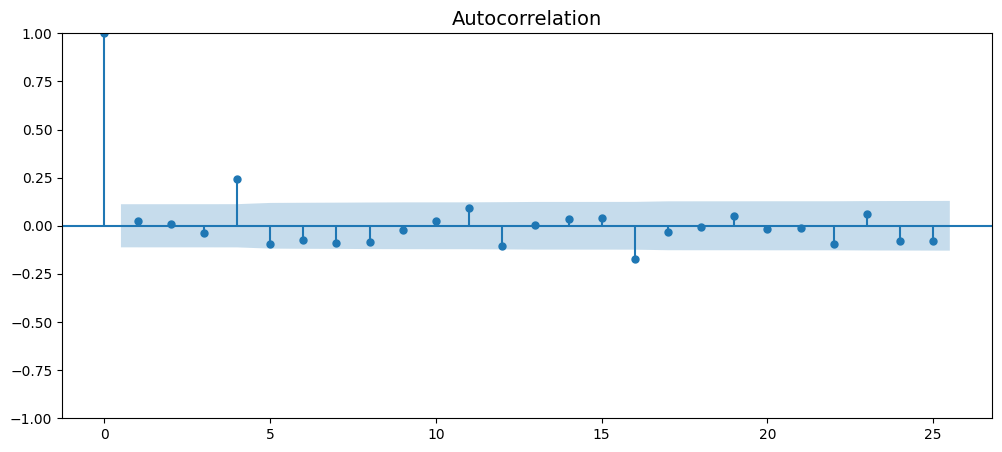

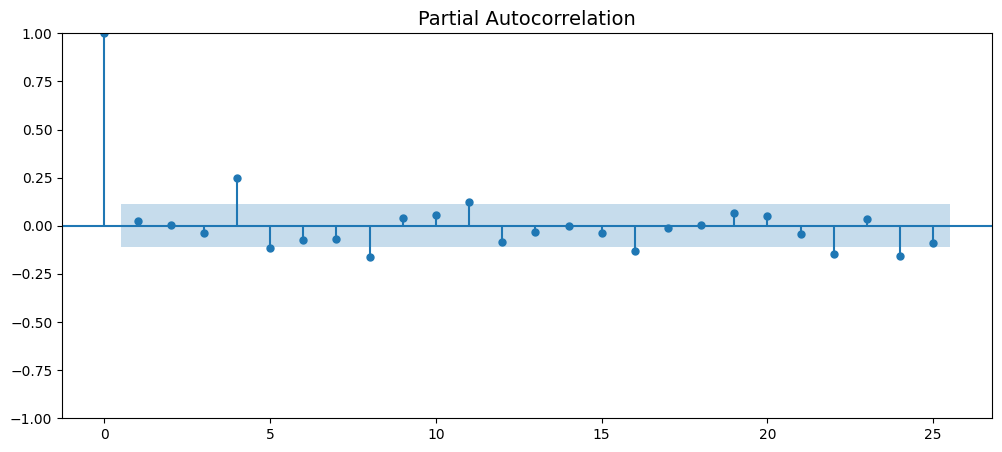

In [ ]:
plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()

<Axes: xlabel='date'>

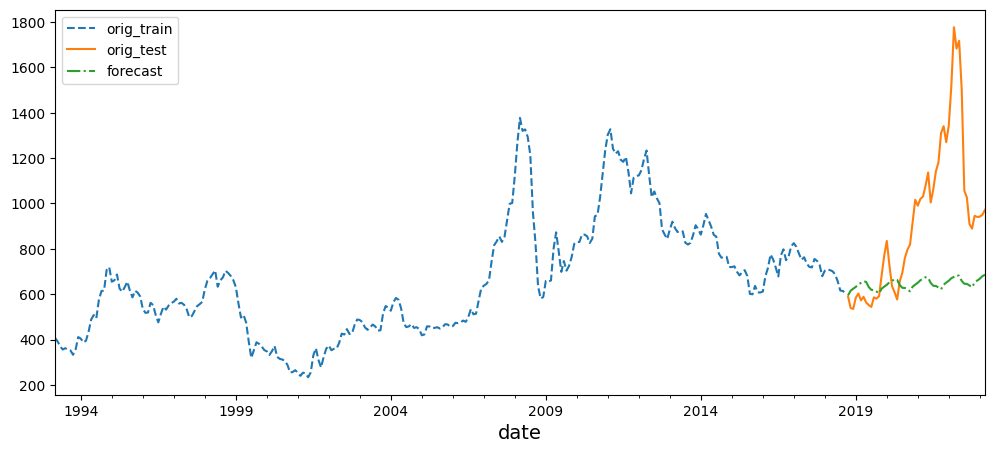

In [ ]:
plot_forecast(model, '1993', df_train, df_test)

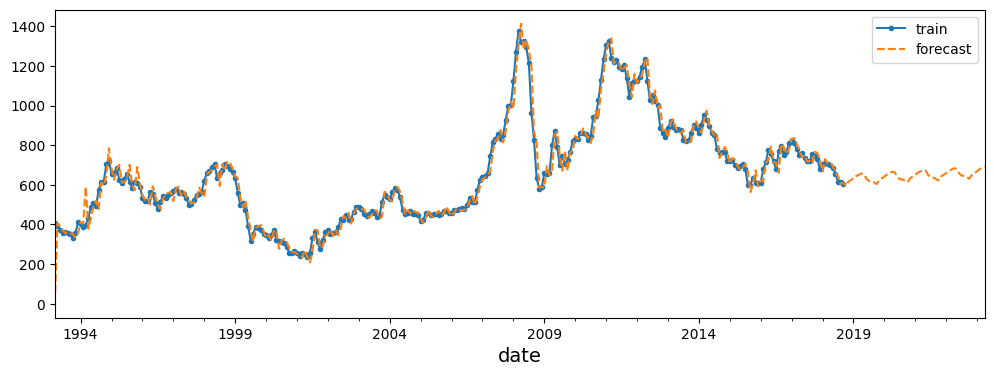

In [ ]:
n = df.shape[0]
df_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

####Applying Grid Search to SARIMA Model

In [ ]:
#Applying Grid Search to SARIMA Model
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(df_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = df_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 2min, sys: 2.67 s, total: 2min 3s
Wall time: 2min 5s


In [ ]:
best_model = get_best_model(score, 'AIC')

Best model: 187 with lowest AIC score: 2875.154114900263


In [ ]:
results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,187,"(2, 1, 2)","(0, 1, 1)",2875.154115,2875.462938,2896.941386,3.226229,414.604287,0.274465,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,115,"(1, 1, 2)","(0, 1, 1)",2875.280896,2875.500676,2893.436955,3.228824,414.955084,0.274492,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,119,"(1, 1, 2)","(1, 1, 1)",2877.112083,2877.420907,2898.899354,3.217298,413.579935,0.273774,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,191,"(2, 1, 2)","(1, 1, 1)",2877.322399,2877.735683,2902.740882,3.213925,413.106212,0.273769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,163,"(2, 0, 2)","(0, 1, 1)",2882.147363,2882.455056,2903.956101,3.195373,410.829714,0.272616,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,43,"(0, 1, 2)","(0, 1, 1)",2883.121038,2883.267023,2897.645885,3.212608,413.219029,0.272821,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,139,"(1, 2, 2)","(0, 1, 1)",2883.426697,2883.647285,2901.564803,4.129041,512.445679,0.346672,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,67,"(0, 2, 2)","(0, 1, 1)",2883.82956,2883.97608,2898.340044,4.117126,511.194317,0.34557,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,167,"(2, 0, 2)","(1, 1, 1)",2884.118137,2884.529901,2909.561664,3.196124,410.929405,0.272664,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,47,"(0, 1, 2)","(1, 1, 1)",2884.917666,2885.137446,2903.073725,3.201142,411.846873,0.272118,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [ ]:
results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()
results.head(30)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,115,"(1, 1, 2)","(0, 1, 1)",2875.280896,2875.500676,2893.436955,3.228824,414.955084,0.274492,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,187,"(2, 1, 2)","(0, 1, 1)",2875.154115,2875.462938,2896.941386,3.226229,414.604287,0.274465,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",2883.121038,2883.267023,2897.645885,3.212608,413.219029,0.272821,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,67,"(0, 2, 2)","(0, 1, 1)",2883.82956,2883.97608,2898.340044,4.117126,511.194317,0.34557,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,119,"(1, 1, 2)","(1, 1, 1)",2877.112083,2877.420907,2898.899354,3.217298,413.579935,0.273774,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,139,"(1, 2, 2)","(0, 1, 1)",2883.426697,2883.647285,2901.564803,4.129041,512.445679,0.346672,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,191,"(2, 1, 2)","(1, 1, 1)",2877.322399,2877.735683,2902.740882,3.213925,413.106212,0.273769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,47,"(0, 1, 2)","(1, 1, 1)",2884.917666,2885.137446,2903.073725,3.201142,411.846873,0.272118,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,71,"(0, 2, 2)","(1, 1, 1)",2885.781322,2886.001911,2903.919428,4.120505,511.554083,0.34586,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,163,"(2, 0, 2)","(0, 1, 1)",2882.147363,2882.455056,2903.956101,3.195373,410.829714,0.272616,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [ ]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 2891.0536946178136,
 'AICc': 2891.3636577174448,
 'BIC': 2912.8194212999574,
 'RMSPE': 4.154195972804033,
 'RMSE': 515.1036317110245,
 'MAPE': 0.34894322837561526,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f6e2263a550>}

In [ ]:
df_train

,cpo_pri
date,
1993-03-01,408.00
1993-04-01,392.00
1993-05-01,371.00
1993-06-01,356.00
1993-07-01,362.00
...,...
2018-05-01,687.29
2018-06-01,656.50
2018-07-01,616.14


<Axes: xlabel='date'>

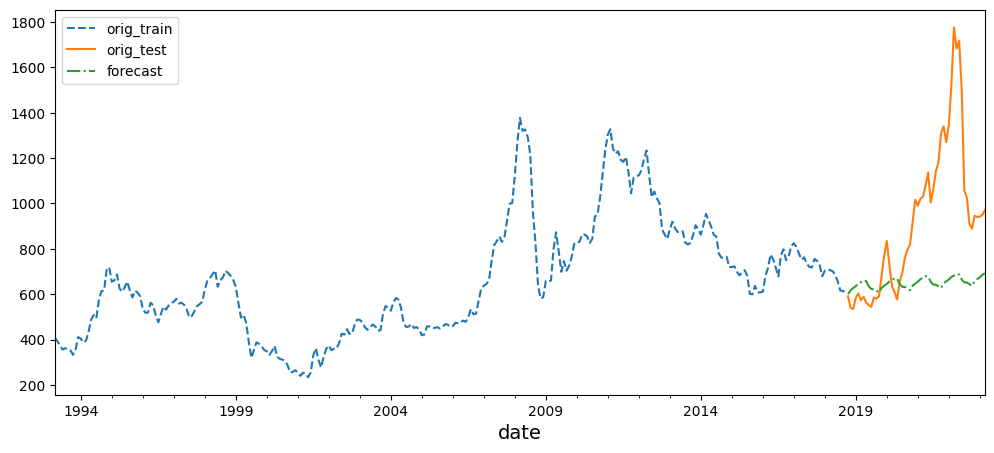

In [ ]:
plot_forecast(best_model, '1993', df_train, df_test)